In [1]:
import numpy as np
import gvar as gv
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

## Definitions and Setting Up the Simulation

The following is a list of each of the strategies or "predictors" that the agents may employ to map the previous week's attendance figures into the next week. Depending on the specific problem we're studying, the agents could have access to all of these strategies, a subset of them, or be restricted to one strategy.
0. avg: Takes the average of the previous week's figures
1. same: Returns the same number as last week
2. twocycle: Returns the same number as two weeks ago
3. threecycle: Returns the same number as three weeks ago
4. fourcycle: Returns the same number as four weeks ago
5. standard_dev_try: If the previous week's attendance was greater than two weeks ago, returns N minus the standard deviation of the previous week's figures. Otherwise returns the standard deviation of the previous attendances.
6. mirror: Mirrors the previous week's attendance around $N/2$. So if $N=100$, an attendance of 35 maps to a prediction of 65.
7. weak_predict: If the previous two week's attendances were > $m$, predict $> m$, and vice-versa. If the last two weeks weren't consistent with respect to $m$ then take the average of the last two weeks.  
8. mad_cow: Randomly guess how many people will attend, between 0 and $N$ inclusive. This is the only strategy that each agent is given in the "Totally Random Strategies" section of this notebook.
9. this_looks_bad: If the attendance jumped by more than 20% of the total number of agents between two weeks ago and last week, predict an attendance $> m$. Otherwise predict last week's attendance.
10. roll20: Randomly guess that between 1 and 20 percent of the total agent number will show up.
11. seventyorbust: Always guess that 70 percent of people will show up
12. twentyorbust: Always guess that 20 percent of people will show up

11 and 12 are useful for demonstrating the Nash equilibrium results of this game.

In [2]:
# Build predictors - functions that map previous week's attendance figures into the next week
def avg(prev_weeks):
    return sum(prev_weeks)/len(prev_weeks)

def same(prev_weeks):
    return prev_weeks[-1]

def twocycle(prev_weeks):
    return prev_weeks[-2]

def threecycle(prev_weeks):
    return prev_weeks[-3]

def fourcycle(prev_weeks):
    return prev_weeks[-4]

def standard_dev_try(prev_weeks): # calculate standard deviation of previous attendance, N - std if trending up
    if prev_weeks[-1]-prev_weeks[-2]>0:
        return N - np.std(prev_weeks)
    return np.std(prev_weeks)

def mirror(prev_weeks): # mirror attendance around N/2 from last week, so with N=100, 35 -> 65
    return N-prev_weeks[-1]

def weak_predict(prev_weeks): # if previous two weeks > m, predict > m, and vice-versa. If unclear take avg of last two weeks
    if prev_weeks[-1] > m and prev_weeks[-2] > m:
        return random.randint(m+1,N)
    if prev_weeks[-1] < m and prev_weeks[-2] < m:
        return random.randint(0,m-1)
    return (prev_weeks[-1] + prev_weeks[-2])/2

def mad_cow(prev_weeks): # randomly guess how many total people will show up
    return random.randint(0,N) # (0, N) makes you go exactly m/(N+1) of the time in the long term

def this_looks_bad(prev_weeks): # if there was a jump in numbers of 20 percent or more over last two times, predict > m. Otherwise predict the last number
    if prev_weeks[-1]-prev_weeks[-2] >= 20*N/100:
        return random.randint(m+1,N)
    return prev_weeks[-1]

def roll20(prev_weeks): # Thinks that between 1 and 20 percent of people will show up
    return random.randint(1,20)*N/100

def seventyorbust(prev_weeks): # always thinks that 70 percent of people will show up
    return 70*N/100

def twentyorbust(prev_weeks): # always thinks that 20 percent of people will show up
    return 20*N/100
        
# Create a dispatch mapping for each predictor to a number by using a dictionary
dispatch = {
    0: avg,
    1: same,
    2: twocycle,
    3: threecycle,
    4: fourcycle,
    5: standard_dev_try,
    6: mirror,
    7: weak_predict,
    8: mad_cow,
    9: this_looks_bad,
    10: roll20,
    11: seventyorbust,
    12: twentyorbust
}

def prophesy(predict_num, prev_weeks):
    return dispatch[predict_num](prev_weeks)


# Advance the simulation in time as long as you want: people keep their predictors if they work, choose best one of others if they don't
def run_simulation(agent_predictors, active_predictors, prev_weeks, run_time_in_weeks):
    i=1
    while i <= run_time_in_weeks:
        
        # Have each person make their guesses using their active predictor number and the list of previous week's attendances
        guesses = []
        for agent in range(N):
            guesses.append(prophesy(active_predictors[agent], prev_weeks))

        # Count how many people will attend (their prediction is < m), the people that will stay home are N-(# of attendants)
        num_attend = len([g for g in guesses if g<m])
        num_stay_home = N-num_attend # Note: People stay home if prediction is >= m


        # For each agent, evaluate the performance of the predictors and update their accuracies, reassigning their active 
        # predictor if necessary; if active predictor did not work, look at how the remaining predictors would have done 
        # and pick one based on that

        for agent in range(N):
            
            # A person's strategy is considered successful if they chose to go and <= m people went, or if they chose to stay
            # home and >= m people went
            success_condition = (num_attend <= m and prophesy(active_predictors[agent], prev_weeks) < m) or (num_attend >= m and prophesy(active_predictors[agent], prev_weeks) >= m)
            
            if not(success_condition):

                if num_attend < m:
                    predictors = np.array([prophesy(agent_predictors[agent][i], prev_weeks) for i in range(k)])
                    model_successes = predictors[predictors < m]
                    num_successful_models = model_successes.size

                    # Randomly pick one of the predictors if none of them would have worked last week
                    if num_successful_models == 0:
                        #print("Guess I'm guessing!")
                        model_choice_index = random.randint(0,k-1)
                        active_predictors[agent]=agent_predictors[agent][model_choice_index]

                    # If one or more predictors would have worked, randomly pick from successful predictors     
                    if num_successful_models >= 1:
                        #print("What to choose...")
                        model_indices = [i for i, x in enumerate(predictors<m) if x]
                        active_predictors[agent]=agent_predictors[agent][random.choice(model_indices)]             

                if num_attend > m:
                    predictors = np.array([prophesy(agent_predictors[agent][i], prev_weeks) for i in range(k)])
                    model_successes = predictors[predictors > m]
                    num_successful_models = model_successes.size

                    if num_successful_models == 0:
                        #print("Guess I'm guessing!")
                        model_choice_index = random.randint(0,k-1)
                        active_predictors[agent]=agent_predictors[agent][model_choice_index]

                    if num_successful_models > 1:
                        #print("What to choose...")
                        model_indices = [i for i, x in enumerate(predictors>m) if x]
                        active_predictors[agent]=agent_predictors[agent][random.choice(model_indices)]

            # if successful, increase agent's number of successes by one
            else:
                agent_successes[agent] += 1
        
        # Add new attendance to list of previous week's attendance
        prev_weeks.append(num_attend)

        # Return back to prediction stage with updated attendance list, repeat those steps for as many weeks as desired
        i += 1

## Original El Farol Bar Problem

Each person has a fixed set of hypotheses. They can switch between these hypotheses over time but cannot change the set of hypotheses that they choose from.

In [3]:
# Initialize the problem
N = 10000; # number of people considering going to the bar
m = .6*N; # maximum number of attendees above which people stop having fun at the bar and would rather be home
d = 20; # the number of previous weeks for which everyone has attendance info
k = 3; # number of hypotheses or "ideas" that each person possesses
t = 60; # time we advance forward in weeks
last_weeks = [random.randint(0,N) for i in range(d)]
print(last_weeks)

# Randomly assign k of the predictors to each of the agents, making the first one in the list the initial active predictor
agent_predictors = []
for agent in range(N):
    agent_predictors.append(np.random.choice(13, k, replace=False).tolist()) # Must edit the first number in random.choice() if you change the number of defined predictors

active_predictors = [x[0] for x in agent_predictors]

# Initialize list of each agent's number of successes with zeros
agent_successes = [0] * N

[943, 7875, 372, 9575, 4552, 4708, 7926, 8748, 6556, 9073, 7946, 8442, 3083, 7324, 828, 9438, 3711, 2948, 1573, 7696]


0.23353402934922962


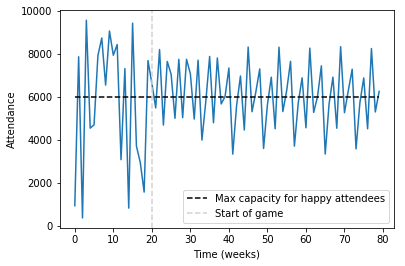

In [4]:
# Run the simulation
run_simulation(agent_predictors, active_predictors, last_weeks, t)
times = np.arange(d+t)
f = plt.figure()
plt.plot(times, last_weeks)
plt.plot(times, [m] * (d + t), 'k--', label = 'Max capacity for happy attendees') # plot the mean m, the cutoff number for happy attendees
plt.axvline(d, c = 'lightgrey', ls = '--', label = 'Start of game') # Note the first d weeks are the random input data of previous week's attendances that everyone knows
plt.ylabel('Attendance')
plt.xlabel('Time (weeks)')
plt.legend()
#print(last_weeks)

# Calculate the coefficient of variation (CV, standard deviation divided by mean) of the 60 week simulation results
attendance_after_start = last_weeks[d::]
mean = np.mean(attendance_after_start)
std = np.std(attendance_after_start)
CV = std/mean
print(CV)

# Save high quality png of figure
#f.savefig("El Farol Attendances for Pure and Mixed Strategies.png", bbox_inches='tight', dpi = 600)

I'm interested in seeing what the overall individual success numbers (x) versus the number of people who achieved those numbers (y) looks like. Is there some type of discrete distribution to it? I also worry that this distribution may depend on my specific simulation of the problem, and a more general learning model or something else would give a different distribution.

22.4605
5.0043420896257675


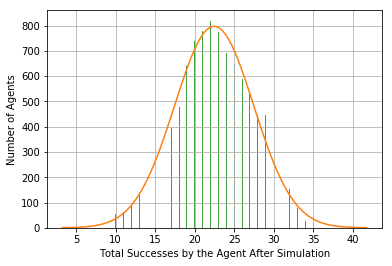

In [5]:
mean,std = norm.fit(agent_successes)
print(mean)
print(std)

#histbins = max(agent_successes)-min(agent_successes)
q25, q75 = np.percentile(agent_successes,[.25,.75])
bin_width = 2*(q75 - q25)*len(agent_successes)**(-1/3)
histbins = int(round((max(agent_successes) - min(agent_successes))/bin_width)) # Bins selected according to Freedman-Diaconis rule
f = plt.figure()
plt.hist(agent_successes, histbins, facecolor='g', alpha=0.75) # Density = True would make the histogram a probability density
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = N*norm.pdf(x, mean, std)
plt.plot(x, y, label = 'Gaussian fit')
plt.ylabel('Number of Agents')
plt.xlabel('Total Successes by the Agent After Simulation')
#plt.title('Histogram of Agent Success Numbers')
plt.grid(True)
plt.show()

# Save high quality png of figure
#f.savefig("Success Histogram for Pure and Mixed Strategies.png", bbox_inches='tight', dpi = 600)

From a few simulations it's clear that this distribution has a mean, but it's not Gaussian. There's a strange peak near the edge of the right side (large number of successes).

## Pure Strategies and Weak Nash Equilibria

In [6]:
# Initialize the problem
N = 10000; # number of people considering going to the bar
m = .6*N; # maximum number of attendees above which people stop having fun at the bar and would rather be home
d = 20; # the number of previous weeks for which everyone has attendance info
k = 1; # number of hypotheses or "ideas" that each person possesses
t = 60; # time we advance forward in weeks
last_weeks = [random.randint(0,N) for i in range(d)]
print(last_weeks)

# Assign the pure strategy twentyorbust (always guess 20% of the N people will show up) to m of the people,
# and assign the pure strategy seventyorbust(always guess 70% of the N people will show up) to the remaining
# N-m people
agent_predictors = []
for agent in range(int(m)):
    agent_predictors.append([12]) # format for giving everyone the same strategy
    
for agent in range(int(m), N):
    agent_predictors.append([11])

active_predictors = [x[0] for x in agent_predictors]

# Initialize list of each agent's number of successes with zeros
agent_successes = [0] * N

[6876, 8150, 1960, 6566, 5384, 723, 7467, 9422, 7968, 1951, 7044, 4531, 3510, 1966, 786, 8883, 9199, 903, 3862, 1771]


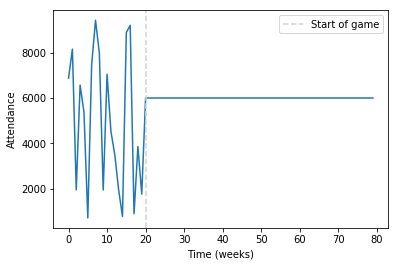

In [7]:
# Run the simulation
run_simulation(agent_predictors, active_predictors, last_weeks, t)
times = np.arange(d+t)
f = plt.figure()
plt.plot(times, last_weeks) 
#plt.plot(times, [m] * (d + t), 'k--', label = 'Max capacity for happy attendees') # plot the mean m, the cutoff number for happy attendees
plt.axvline(d, c = 'lightgrey', ls = '--', label = 'Start of game') # Note the first d weeks are the random input data of previous week's attendances that everyone knows
plt.ylabel('Attendance')
plt.xlabel('Time (weeks)')
plt.legend()
#print(last_weeks)

# Save high quality png of figure
#f.savefig("El Farol Attendances for Pure-Strategy Nash Equilibrium.png", bbox_inches='tight', dpi = 600)

60.0


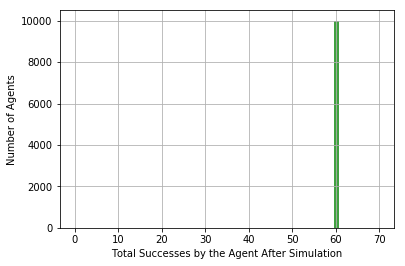

In [8]:
print(np.mean(agent_successes))
f = plt.figure()
#histbins = max(agent_successes)-min(agent_successes) # Doesn't work as number of bins for histogram because all agents have same number of successes - t, the number of weeks
plt.hist(agent_successes, t, range=(0,t+10), facecolor='g', alpha=0.75) # Density = True would make the histogram a probability density
plt.ylabel('Number of Agents')
plt.xlabel('Total Successes by the Agent After Simulation')
#plt.title('Histogram of Agent Success Numbers')
plt.grid(True)
plt.show()

# Save high quality png of figure
#f.savefig("Success Histogram for Pure-Strategy Nash Equilibrium.png", bbox_inches='tight', dpi = 600)

## Totally Random Strategies

In [9]:
# Initialize the problem
N = 10000; # number of people considering going to the bar
m = .6*N; # maximum number of attendees above which people stop having fun at the bar and would rather be home
d = 20; # the number of previous weeks for which everyone has attendance info
k = 1; # number of hypotheses or "ideas" that each person possesses
t = 60; # time we advance forward in weeks
last_weeks = [random.randint(0,N) for i in range(d)]
print(last_weeks)

# Assign predictor 8 (mad_cow) to each of the agents, so that everyone randomly guesses next week's attendance
agent_predictors = []
for agent in range(N):
    agent_predictors.append([8]) # format for giving everyone the same strategy

active_predictors = [x[0] for x in agent_predictors]

# Initialize list of each agent's number of successes with zeros
agent_successes = [0] * N

[1500, 3664, 79, 509, 1459, 7489, 6355, 7158, 709, 1963, 8205, 944, 7880, 8340, 7865, 497, 497, 6893, 8023, 442]


0.008078533939537419


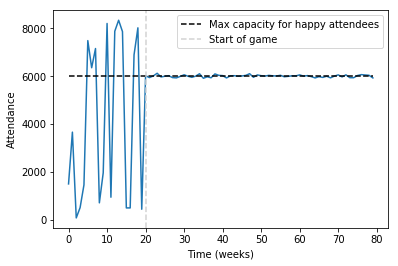

In [10]:
# Run the simulation
run_simulation(agent_predictors, active_predictors, last_weeks, t)
times = np.arange(d+t)
f = plt.figure()
plt.plot(times, last_weeks) 
plt.plot(times, [m] * (d + t), 'k--', label = 'Max capacity for happy attendees') # plot the mean m, the cutoff number for happy attendees
plt.axvline(d, c = 'lightgrey', ls = '--', label = 'Start of game') # Note the first d weeks are the random input data of previous week's attendances that everyone knows
plt.ylabel('Attendance')
plt.xlabel('Time (weeks)')
plt.legend()
#print(last_weeks)

# Calculate the coefficient of variation (CV, standard deviation divided by mean) of the 60 week simulation results
attendance_after_start = last_weeks[d::]
mean = np.mean(attendance_after_start)
std = np.std(attendance_after_start)
CV = std/mean
print(CV)

# Save high quality png of figure
#f.savefig("El Farol Attendances for Fully Random Guesses.png", bbox_inches='tight', dpi = 600)

[6021, 5943, 6013, 6124, 5969, 6000, 6023, 5943, 5932, 5994, 6061, 6000, 5955, 6004, 6104, 5915, 5978, 5935, 6097, 6037, 6026, 5929, 6016, 6023, 6001, 6012, 6035, 6106, 5956, 6055, 6023, 6008, 6036, 6017, 6011, 6039, 5978, 5996, 6017, 6015, 6057, 6004, 6027, 5984, 5930, 5983, 5951, 6001, 5933, 6005, 6057, 5971, 6058, 5940, 5938, 6030, 6067, 6052, 6039, 5929]


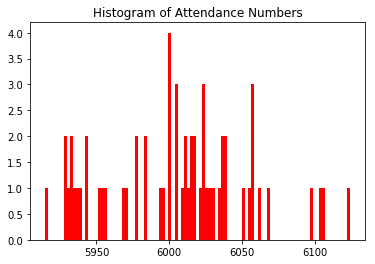

In [11]:
attendance_after_start = last_weeks[d::]
print(attendance_after_start)
q25, q75 = np.percentile(attendance_after_start,[.25,.75])
bin_width = 2*(q75 - q25)*len(attendance_after_start)**(-1/3)
histbins = int(round((max(attendance_after_start) - min(attendance_after_start))/bin_width)) # Bins selected according to Freedman-Diaconis rule
plt.hist(attendance_after_start, histbins, facecolor='r')
plt.title('Histogram of Attendance Numbers')
plt.show()

29.0821
3.751154434304192


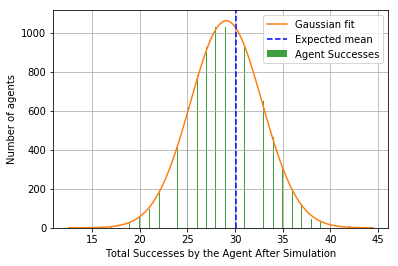

In [12]:
mean,std = norm.fit(agent_successes)
print(mean)
print(std)

#histbins = max(agent_successes)-min(agent_successes)
q25, q75 = np.percentile(agent_successes,[.25,.75])
bin_width = 2*(q75 - q25)*len(agent_successes)**(-1/3)
histbins = int(round((max(agent_successes) - min(agent_successes))/bin_width)) # Bins selected according to Freedman-Diaconis rule
f = plt.figure()
plt.hist(agent_successes, histbins, facecolor='g', alpha = 0.75, label = 'Agent Successes') # Density = True would make the histogram a probability density
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = N*norm.pdf(x, mean, std)
plt.plot(x, y, label = 'Gaussian fit')
plt.axvline(.501085*t, c = 'blue', ls = '--', label = 'Expected mean') # N=10000 success probability from Mathematica calculation
plt.ylabel('Number of agents')
plt.xlabel('Total Successes by the Agent After Simulation')
#plt.title('Histogram of Agent Success Numbers')
plt.grid(True)
plt.legend()
plt.show()

# Save high quality png of figure
#f.savefig("Success Histogram for Fully Random Guesses.png", bbox_inches='tight', dpi = 600)

### Why do agent successes converge to $t/2$ for large $N$ with everyone randomly guessing?

Notice that for large $N$ the number of agent successes converge to a Gaussian centered on $t/2$ if everyone adopts the pure strategy of a totally random guess! We made a simple argument about why this is the case in the blog post, but I'll now show that this result also pops out when you apply the relevant equations from probability theory.

First let's restate the game-theoretic definition of this problem that I gave in the blog post. From our assumption about the traffic history being available to everyone afterwards, we will say that a driver is happy with their decision in two possible outcomes of the day:

1. If they chose to drive and ≤ $m$ people drove in total (no traffic).
1. If they chose not to drive and ≥ $m$ people drove in total (traffic).


Denoting the decision to drive by $x=1$ and the decision to stay home by $x=0$, and letting $n$ be the actual number of drivers who drive on the day ($n$ ≤ $N$), this corresponds to the following payoff function:

\begin{equation}
U(x,n) = 
\begin{cases} 
      1, & \text{if $x=0$ and $n \geq m$}  \\
      0, & \text{if $x=0$ and $n < m$} \\
      0, & \text{if $x=1$ and $n > m$} \\
      1, & \text{if $x=1$ and $n\leq m$}
\end{cases}
\end{equation}

Recalling that a driver decides to stay if they expect traffic to occur (i.e. their prediction is $\geq m$ total people on the road), there are $m$ predictions for which the driver decides to go $(0, \ldots, m-1
)$ and $N-m+1$ predictions for which they stay home $(m, \ldots, N)$. Thus the probability that an individual driver goes is $p = \frac{m}{N+1}$, and the probability that they stay is $1-p=\frac{N-m+1}{N+1}$. The probability that an individual driver maximizes their utility is a sum of the probabilities of success for each choice:

\begin{equation}
\tag{1}
P(U=1) = P(U = 1 \text{ and } x = 1) + P(U = 1 \text{ and } x = 0).
\end{equation}

Now by the definition of the conditional probability, 

\begin{equation}
\tag{2}
P(U = 1 \text{ and } x = 1) = P(x = 1) \times P(U = 1 | x = 1) = p \times P(U = 1 | x = 1),
\end{equation}

and similarly for $P(U = 1 \text{ and } x = 0)$. Since the likelihood of success depends on the total number $n$ of drivers who show up independently on the day and each one drives with probability $p$, we're looking at a binomial distribution:

\begin{aligned}
P(U = 1 | x = 1) = \sum_{n=0}^{m-1} P(\text{exactly $n$ of the $N-1$ other people drive}) = \sum_{n=0}^{m-1} {N-1 \choose n}p^{n}(1-p)^{N-1-n}.
\end{aligned}

In the same way we find the following probability of success given that the driver stays home: 

\begin{aligned}
P(U = 1 | x = 0) = P(\geq m \text{ of the other $N-1$ people drive}) = \sum_{n=m}^{N-1} {N-1 \choose n}p^{n}(1-p)^{N-1-n}.
\end{aligned}

Plugging in $m=0.6N$ and a simulation time of $t=60$ weeks, we can use Mathematica to see what increasing $N$ does to $p$ and the success probabilities for both of the driver's choices:

| $N$      | $p$     | $P$$($$U = 1$ \| $x = 1$$)$ | $P$$($$U = 1$ \| $x = 0$$)$ |
|----------|---------|---------------------|---------------------|
| $10$     | .545455 | .649063             | .350937             |
| $100$    | .594059 | .553452             | .446548             |
| $1000$   | .599401 | .517141             | .482859             |
| $10000$  | .59994  | .505428             | .494572             |
| $10^{5}$ | .599994 | .501717             | .498283             |
| $10^{6}$ | .599999 | .500543             | .499457             |


As $N$ increases we find that the success probabilities for both of the driver's choices approach 1/2. Using equations (1) and (2) we can find the probability that an individual driver maximizes their utility as $N$ increases, 

| $N$      | $P$$($$U = 1$$)$ |
|----------|------------------|
| $10$     | .513551          |
| $100$    | .510055          |
| $1000$   | .503408          |
| $10000$  | .501085          |
| $10^{5}$ | .500343          |
| $10^{6}$ | .500109          |

which again approaches 1/2 as $N\rightarrow \infty$. The expected number of successes for each agent after time $t$ is just $P(U=1)\times t$, so with the numbers for our particular random strategy simulation we get $t/2 = 30$ expected successes per agent.

## Comparing Real Traffic Data to El Farol Bar Problem

Below, we look at the variation in northbound traffic numbers at 12 pm in Delaware from Route 1 south of the Indian River Inlet Bridge, from 8/15/11 to 8/25/11. Data obtained from Figure 2 of the paper "Learning from traffic data collected before, during and after a hurricane" by Erick Archibald and Sue McNeil.

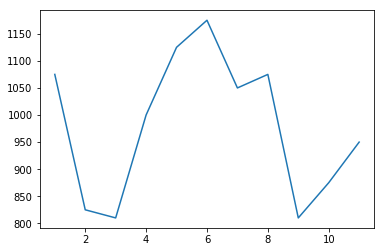

In [13]:
trafficat12 = [1075, 825, 810, 1000, 1125, 1175, 1050, 1075, 810, 875, 950]
dayarray = list(range(1, len(trafficat12)+1))
plt.plot(dayarray, trafficat12)

Maybe there are fluctuations around a mean? This isn't enough data to really see longer term traffic trends though. 

Instead we can pull continuous data from CDOT (Colorado Department of Transportation) on an active road in Denver. Specifically I'll use the 12 pm and 5 pm data from Interstate 70 East (Station 000511) over the months of January-March 2021, separating out the primary (P, east) and secondary (S, west) directions. The count data for a given time refers to the total number of cars that were counted over one hour starting at that time (e.g. starting at 12 pm and ending at 1 pm). You can access the same data at the following CDOT Traffic Data website: <https://dtdapps.coloradodot.info/otis/TrafficData>

In [14]:
trafficdata = pd.read_excel(r'DenverTraffic_JanFebMar2021_StationID00051.xlsx')
primary_data = pd.DataFrame(trafficdata[trafficdata['Dir'] == 'P'])
secondary_data = pd.DataFrame(trafficdata[trafficdata['Dir'] == 'S'])

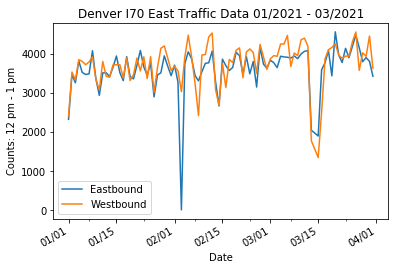

In [15]:
## 12 pm - 1 pm traffic count plots

fig, ax = plt.subplots()
p1, = ax.plot('Count Date', '12h', data = primary_data)
p2, = ax.plot('Count Date', '12h', data = secondary_data)
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)

# Major ticks every month, minor ticks roughly every quarter month
fmt_monthly = mdates.MonthLocator(bymonthday = [1, 15])
ax.xaxis.set_major_locator(fmt_monthly)

days = mdates.MonthLocator(bymonthday = [7, 15, 23])
ax.xaxis.set_minor_locator(days)

fig.autofmt_xdate()

ax.legend([p1, p2], ['Eastbound', 'Westbound'], loc='lower left')
ax.set_xlabel('Date')
ax.set_ylabel('Counts: 12 pm - 1 pm')
ax.set_title('Denver I70 East Traffic Data 01/2021 - 03/2021')
plt.show()

# Save high quality png of figure
#fig.savefig("12hDenverTraffic.png", bbox_inches='tight', dpi = 600)

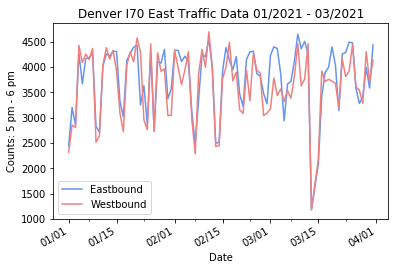

In [16]:
## 5 pm - 6 pm traffic count plots

fig, ax = plt.subplots()
p3, = ax.plot('Count Date', '17h', data = primary_data, color = 'cornflowerblue')
p4, = ax.plot('Count Date', '17h', data = secondary_data, color = 'lightcoral')
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)

# Major ticks every month, minor ticks roughly every quarter month
fmt_monthly = mdates.MonthLocator(bymonthday = [1, 15])
ax.xaxis.set_major_locator(fmt_monthly)

days = mdates.MonthLocator(bymonthday = [7, 15, 23])
ax.xaxis.set_minor_locator(days)

fig.autofmt_xdate()

ax.legend([p3, p4], ['Eastbound', 'Westbound'], loc='lower left')
ax.set_xlabel('Date')
ax.set_ylabel('Counts: 5 pm - 6 pm')
ax.set_title('Denver I70 East Traffic Data 01/2021 - 03/2021')
plt.show()

# Save high quality png of figure
#fig.savefig("17hDenverTraffic.png", bbox_inches='tight', dpi = 600)

The halt in eastbound traffic at noon on February 3rd was caused by a large crash which occured before noon that day: <https://www.denverpost.com/2021/02/03/one-dead-two-injured-crash-i-70/>

and the big drop in both directions of traffic at both times of day from March 13 through March 15 was due to a historic snowstorm throughout much of Colorado, but particularly centered around the Denver/Fort Collins area:
<https://www.weather.gov/bou/March13_14_2021Storm>

### Coefficient of Variation for Denver Traffic Data and El Farol and Random Guesses Simulations
#### Denver Traffic Data

In [17]:
# Find means and standard deviations for the 12 pm - 1 pm and 5 pm - 6 pm traffic count datasets (primary and secondary directions)
p12h = primary_data.iloc[:,14]
s12h = secondary_data.iloc[:,14]
p17h = primary_data.iloc[:,19]
s17h = secondary_data.iloc[:,19]

meanp12h,stdp12h = norm.fit(p12h)
means12h,stds12h = norm.fit(s12h)
meanp17h,stdp17h = norm.fit(p17h)
means17h,stds17h = norm.fit(s17h)

# Calculate coefficient of variation (CV, standard deviation divided by mean)
CV_p12h = stdp12h/meanp12h
print(CV_p12h)
CV_s12h = stds12h/means12h
print(CV_s12h)
CV_p17h = stdp17h/meanp17h
print(CV_p17h)
CV_s17h = stds17h/means17h
print(CV_s17h)

0.15998912741021773
0.14929242495496858
0.1734582303041081
0.18197310916905957


#### El Farol and Random Guesses Simulations - Coefficients of Variation from 15 Trials

Original El Farol Bar Problem:
0.24349, 0.20483, 0.18963, 0.21590, 0.22167, 0.24152, 0.19383, 0.20421, 0.23191, 0.22384, 0.19185, 0.19320, 
0.18915, 0.22212, 0.23353     


Totally Random Strategies:
0.00899, 0.00738, 0.00855, 0.00836, 0.00761, 0.00878, 0.00845, 0.00847, 0.00820, 0.00827, 0.00878, 0.00649, 
0.00677, 0.00865, 0.00808

So from these 15 trials the average El Farol CV is 0.21338 and the average random guesses CV is 0.00812.